In [131]:
import pickle as pkl
import pandas as pd
import matplotlib
import os
import re

import collections
import datetime
import time

import geopandas as gpd

import numpy as np

import rasterio

import spacy

import gc

import geopy.distance

nlp = spacy.load('en_core_web_lg')
from sklearn.metrics.pairwise import cosine_similarity

import itertools

import pgeocode

from dateutil.relativedelta import relativedelta

# Indirect
Introduce the SC Data, focusing on transactions between US companies.

In [132]:
c_links = pd.read_csv("../../data/companyData/c_linksUS.csv") # pd.read_csv("../../data/companyData/compustatSCLinked.csv")

c_links['year'] = c_links.srcdate.astype('str').str.slice(0,4).astype('int64')

c_links = c_links[c_links.year > 1999][['year','gvkey','cgvkey','salecs']].\
    rename(columns = {'cgvkey': 'customer_gvkey','gvkey': 'supplier_gvkey'})

c_links['year'] = pd.to_datetime(c_links.year, format = '%Y')


c_links.head()

,year,supplier_gvkey,customer_gvkey,salecs
0,2002-01-01,1013,2136,111.056
1,2004-01-01,1013,2136,104.312
2,2005-01-01,1013,2136,146.000
3,2006-01-01,1013,2136,205.000
4,2007-01-01,1013,2136,236.000


In [133]:
sum(c_links.salecs.isna())

11228

In [134]:
supplierCombos = c_links[['supplier_gvkey', 'customer_gvkey']].drop_duplicates().reset_index(drop = True)

print(supplierCombos.shape)

supplierCombos.head()

(11827, 2)


,supplier_gvkey,customer_gvkey
0,1013,2136
1,1013,9899
2,1021,61494
3,1021,25880
4,1048,11552


We'll follow Barrot Sauvagnat in assuming that a supplier relationship holds for every year between the first and last year in which a customer is reported. This is going to take a little bit of work. We'll try it like this: 
- subset dataframe to a specific supplier-customer pair
- fill in data for every year that's missing

Then, apply this row-wise to all rows of the unique supplierCombos df above using: https://stackoverflow.com/questions/61942138/apply-function-row-wise-to-pandas-dataframe

In [135]:
def fillYear(supplier, customer, scData = c_links):
    c_linksTemp = scData[(scData.supplier_gvkey == supplier) & \
                      (scData.customer_gvkey == customer)].reset_index(drop = True)
    
    # if there are na values and non-na values for the same supplier-cust combination, then 
    # select for only the non-na values, by (1) replacing na with negative, (2) 1
    c_linksTemp['salecs'] = c_linksTemp['salecs'].fillna(-5)
    c_linksTemp = c_linksTemp.loc[c_linksTemp.reset_index().groupby(['year','supplier_gvkey',
                                                                     'customer_gvkey'])['salecs'].idxmax()]
    
    
    # now: find the start and end of the data series
    first = c_linksTemp.year.min() - relativedelta(years = 3)
    last  = c_linksTemp.year.max() + relativedelta(years = 3)
    
    
    c_linksTemp['firstYear'] = c_linksTemp.year.min()
    c_linksTemp['lastYear']  = c_linksTemp.year.max()
    
    
    c_linksTemp = c_linksTemp.set_index('year') 
    
    
    c_linksTemp = c_linksTemp.reindex(pd.date_range(first, last, freq = 'YS')).\
        reset_index().rename(columns = {'index': 'year'})
    
    
    # and impute all values within the series
    c_linksTemp = c_linksTemp.groupby(c_linksTemp.year.dt.time).ffill().bfill()
    
    
    return(c_linksTemp)

Show that this works for one of the supplier rows.

In [136]:
fillYear(supplierCombos.supplier_gvkey[0], supplierCombos.customer_gvkey[0])

,year,supplier_gvkey,customer_gvkey,salecs,firstYear,lastYear
0,1999-01-01,1013.0,2136.0,111.056,2002-01-01,2010-01-01
1,2000-01-01,1013.0,2136.0,111.056,2002-01-01,2010-01-01
2,2001-01-01,1013.0,2136.0,111.056,2002-01-01,2010-01-01
3,2002-01-01,1013.0,2136.0,111.056,2002-01-01,2010-01-01
4,2003-01-01,1013.0,2136.0,111.056,2002-01-01,2010-01-01
5,2004-01-01,1013.0,2136.0,104.312,2002-01-01,2010-01-01
6,2005-01-01,1013.0,2136.0,146.000,2002-01-01,2010-01-01
7,2006-01-01,1013.0,2136.0,205.000,2002-01-01,2010-01-01
8,2007-01-01,1013.0,2136.0,236.000,2002-01-01,2010-01-01
9,2008-01-01,1013.0,2136.0,240.000,2002-01-01,2010-01-01


Now do it for all rows.

In [137]:
start = time.time()
print(c_links.shape)
c_linksImpd_list = supplierCombos.apply(lambda row: fillYear(row['supplier_gvkey'], row['customer_gvkey']), axis = 1)
c_linksImpd_df   = pd.concat(list(c_linksImpd_list))
print(c_linksImpd_df.shape)
print(time.time() - start)

c_linksImpd_df['year'] = c_linksImpd_df.year.dt.year

(47427, 4)
(120797, 6)
73.34816718101501


We had converted some of the na sales values to -5 so that we could deal with duplicated values, by choosing the larger of said values. Switch back to nan so that we are not thrown off when we look for biggest supplier.

In [138]:
c_linksImpd_df.loc[c_linksImpd_df.salecs == -5, 'salecs'] = float('nan')

Partially subset to focus on suppliers in our data.

In [139]:
suppliersOnly = c_linksImpd_df[['year', 'supplier_gvkey']].drop_duplicates()

suppliersOnly.to_csv("../../data/companyData/suppliers.csv")

suppliersOnly.shape

(47251, 2)

In [140]:
customersOnly = c_linksImpd_df[['year', 'customer_gvkey']].drop_duplicates()
customersOnly.shape

(29148, 2)

In [141]:
industries = pd.read_csv("../../data/companyData/gvkeyIndustries.csv").drop(columns = {'Unnamed: 0'})
print(industries)

       gvkey            indGroup
0       1010                manu
1       1043           wholesale
2       1045  transportUtilities
3       1062             finance
4       1075  transportUtilities
...      ...                 ...
31652  37600             finance
31653  37618             finance
31654  37620             finance
31655  37621             finance
31656  37625             finance

[31657 rows x 2 columns]


In [142]:
c_links = c_linksImpd_df.copy()

print(c_links.shape)

print(c_links.head())

industries.columns = ['customer_gvkey','customer_ind']


c_links = c_links.merge(industries)
industries.columns = ['supplier_gvkey','supplier_ind']

c_links = c_links.merge(industries)
print(c_links.head(), c_links.shape)


c_links.to_csv("../../data/companyData/c_links.csv")


(120797, 6)
   year  supplier_gvkey  customer_gvkey   salecs  firstYear   lastYear
0  1999          1013.0          2136.0  111.056 2002-01-01 2010-01-01
1  2000          1013.0          2136.0  111.056 2002-01-01 2010-01-01
2  2001          1013.0          2136.0  111.056 2002-01-01 2010-01-01
3  2002          1013.0          2136.0  111.056 2002-01-01 2010-01-01
4  2003          1013.0          2136.0  111.056 2002-01-01 2010-01-01
   year  supplier_gvkey  customer_gvkey   salecs  firstYear   lastYear  \
0  1999          1013.0          2136.0  111.056 2002-01-01 2010-01-01   
1  2000          1013.0          2136.0  111.056 2002-01-01 2010-01-01   
2  2001          1013.0          2136.0  111.056 2002-01-01 2010-01-01   
3  2002          1013.0          2136.0  111.056 2002-01-01 2010-01-01   
4  2003          1013.0          2136.0  111.056 2002-01-01 2010-01-01   

         customer_ind supplier_ind  
0  transportUtilities         manu  
1  transportUtilities         manu  
2  tra

Let's see how all this translates into different industries. Check how many times different industries show up.

The full count will be roughly 4x whatever is below, assuming we can get a match for roughly all of them (which we should be able to).

In [143]:
c_links[c_links.year.astype(int) > 1999].supplier_ind.value_counts()

manu                  50104
finance               22950
services              17259
mining                 9457
transportUtilities     6402
wholesale              2884
construction           1097
retail                  628
agForFish               194
Name: supplier_ind, dtype: int64

Now see if it's common to have one in and one out of the industries of interest. 

For now, let's keep all the different industry types.

We can always filter later if we need to.


********this is where it would be helpful to check on the abi bits for a given industry, to see if we can get additional matches as well***********

In [144]:
#########################
# get data and reset columns 
gvKey_abiLinkingTable = pd.read_csv('../../data/companyData/sc_linkingTable.csv').drop(columns = ['Unnamed: 0']).\
    drop_duplicates()



base_columns = gvKey_abiLinkingTable.columns 
customer_columns = "customer_" + base_columns
supplier_columns = "supplier_" + base_columns



# merge in customer information
gvKey_abiLinkingTable.columns = customer_columns



print(c_links.shape)
c_linksMerge1 = c_links.merge(gvKey_abiLinkingTable, on ='customer_gvkey')
print(c_links.shape,c_linksMerge1.shape, c_linksMerge1.head())



#########################
# and merge in supplier 
gvKey_abiLinkingTable.columns = supplier_columns

print(c_links.shape)
c_linksMerge2 = c_linksMerge1.merge(gvKey_abiLinkingTable, on ='supplier_gvkey').drop_duplicates()
print(c_linksMerge2.shape)

c_linksMerge2.to_csv("../../data/companyData/clinks_IG_selected.csv")


c_linksMerge2['year'] = pd.to_datetime(c_linksMerge2.year, format = '%Y')


##########################
# get all the company abi
allAbi = c_linksMerge2.customer_abi.append(c_linksMerge2.supplier_abi).drop_duplicates()
allAbi.shape

(120797, 8)
(120797, 8) (112962, 11)    year  supplier_gvkey  customer_gvkey   salecs  firstYear   lastYear  \
0  1999          1013.0          2136.0  111.056 2002-01-01 2010-01-01   
1  2000          1013.0          2136.0  111.056 2002-01-01 2010-01-01   
2  2001          1013.0          2136.0  111.056 2002-01-01 2010-01-01   
3  2002          1013.0          2136.0  111.056 2002-01-01 2010-01-01   
4  2003          1013.0          2136.0  111.056 2002-01-01 2010-01-01   

         customer_ind supplier_ind customer_cstatCompanies  \
0  transportUtilities         manu     verizonmmunications   
1  transportUtilities         manu     verizonmmunications   
2  transportUtilities         manu     verizonmmunications   
3  transportUtilities         manu     verizonmmunications   
4  transportUtilities         manu     verizonmmunications   

  customer_igCompanies  customer_abi  
0  verizonmmunications       7564776  
1  verizonmmunications       7564776  
2  verizonmmunications      

(4082,)

## Relevant Industries

In [145]:
'''c_linksMerge2 = c_linksMerge2[(c_linksMerge2.customer_ind != 'finance') & (c_linksMerge2.customer_ind != 'services') & \
               (c_linksMerge2.supplier_ind != 'finance') & (c_linksMerge2.supplier_ind != 'services')]

c_linksMerge2.shape'''

"c_linksMerge2 = c_linksMerge2[(c_linksMerge2.customer_ind != 'finance') & (c_linksMerge2.customer_ind != 'services') &                (c_linksMerge2.supplier_ind != 'finance') & (c_linksMerge2.supplier_ind != 'services')]\n\nc_linksMerge2.shape"

First, make a sample with the companies on one year of either side of when it reports another customer.

In [146]:
########
hqsOnly = pd.read_csv("../../data/ig_uniqueHQs.csv").drop(columns = {'Unnamed: 0'})

hq = pd.read_csv("../../data/ig_uniqueHQs_multLocations.csv").\
    drop(columns = {'Unnamed: 0'}).\
    rename(columns = {'archive_version_year': 'year'})

hq['year']    = pd.to_datetime(hq.year, format = '%Y')   # hq.year.astype('int64')
hq['zipcode'] = hq.zipcode.astype('str').str.zfill(5)
hqRelevant    = hq[hq.abi.isin(allAbi)].reset_index()



I think many of these don't have a lat-long but do have a zipcode. We should be able to use pgeocode to get an approximate lat-long from the zipcode.

In [147]:
us = pgeocode.Nominatim('us')

for i in range(0, hq.shape[0]):
    if pd.isna(hq.latitude[i]):
        hq.latitude[i]  = us.query_postal_code(hq.zipcode[i]).latitude
        hq.longitude[i] = us.query_postal_code(hq.zipcode[i]).longitude

/Users/brianreed/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/brianreed/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [148]:
hq[hq['longitude'].isna()].abi.unique()

array([  1864149,   5136239,   6484067,   7512304,   7536717, 107286601,
       107358178, 120553524, 306744129, 406330118, 406330126, 433385663,
       441433422, 450510896, 477538250, 902151877, 936186998, 967349333,
         7001068, 510200629, 902180348,   4552857,   6918395, 602875296,
       435965967, 657440202, 670508548, 671873610, 207813429, 252925805])

In [149]:
supplierHQ = hq[['year','abi','latitude','longitude','zipcode']].copy().rename(columns = {'abi':      'supplier_abi',
                                                                        'latitude':  'supplier_latitude',
                                                                        'longitude': 'supplier_longitude',
                                                                        'zipcode': 'supplier_zipcode'})


customerHQ = hq[['year','abi','latitude','longitude','zipcode']].copy().rename(columns = {'abi':      'customer_abi',
                                                                        'latitude':  'customer_latitude',
                                                                        'longitude': 'customer_longitude',
                                                                        'zipcode': 'customer_zipcode'})

In [150]:
print(sum(allAbi.isin(supplierHQ.supplier_abi)) ,
     sum(allAbi.isin(customerHQ.customer_abi)))



4059 4059


Merge to the closest year in either direction

In [151]:
merged_dataframe = pd.merge_asof(c_linksMerge2.sort_values('year'), customerHQ.sort_values('year'), on="year",
                                 by="customer_abi", 
                                direction = "nearest")

print(merged_dataframe.shape)
merged_dataframe.head()

(99854, 17)


,year,supplier_gvkey,customer_gvkey,salecs,firstYear,lastYear,customer_ind,supplier_ind,customer_cstatCompanies,customer_igCompanies,customer_abi,supplier_cstatCompanies,supplier_igCompanies,supplier_abi,customer_latitude,customer_longitude,customer_zipcode
0,1997-01-01,27786.0,11056.0,54.900,2000-01-01,2001-01-01,transportUtilities,mining,aquila,aquila,7693658,chesapeake energy,chesapeake energy,463222893,39.10510,-94.59160,64199
1,1997-01-01,138005.0,1164.0,24.271,2000-01-01,2000-01-01,transportUtilities,services,mci,mci,712125533,lexent,lexent,544364045,32.30014,-90.18116,39201
2,1997-01-01,63766.0,1045.0,597.201,2000-01-01,2003-01-01,transportUtilities,services,american airlines,american airlines,7501711,sabre,sabre,416062792,32.88270,-97.03714,75261
3,1997-01-01,138005.0,13440.0,75.182,2000-01-01,2002-01-01,transportUtilities,services,level 3mmunications,level 3mmunications,463236547,lexent,lexent,544364045,39.92060,-105.14427,80021
4,1997-01-01,63766.0,10946.0,311.583,2000-01-01,2001-01-01,transportUtilities,services,us airways,us airways,441439718,sabre,sabre,416062792,38.85292,-77.04895,22202


In [152]:
c_linksMerge3 = pd.merge_asof(merged_dataframe.sort_values('year'), supplierHQ.sort_values('year'), on="year",
                                 by="supplier_abi", 
                                direction = "nearest")

# c_linksMerge2.merge(supplierHQ).merge(customerHQ)


print(c_linksMerge3.shape)


c_linksMerge3 = c_linksMerge3[(~c_linksMerge3.supplier_latitude.isna()) & (~c_linksMerge3.customer_latitude.isna())]

print(c_linksMerge3.shape)

c_linksMerge3 = c_linksMerge3.reset_index(drop = True)

(99854, 20)
(98787, 20)


In [153]:
c_linksMerge3.salecs.sum()/c_linksMerge2.salecs.sum()

0.9889415923171958

Now, find the distances between suppliers.

In [154]:
c_linksMerge3['dist'] = 0

for i in range(0,c_linksMerge3.shape[0]):
    c_linksMerge3.dist[i] = geopy.distance.geodesic((c_linksMerge3.customer_latitude[i],c_linksMerge3.customer_longitude[i]), \
                                                             (c_linksMerge3.supplier_latitude[i],c_linksMerge3.supplier_longitude[i])).km

/Users/brianreed/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


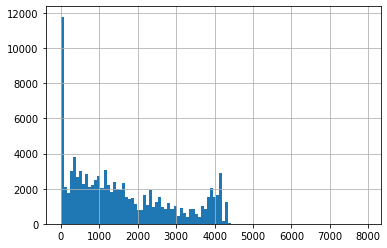

In [155]:
c_linksMerge3.dist.hist(bins = 100)

In [156]:
c_linksMerge3.to_csv("../../data/companyData/supplierCustomerHQs.csv")

In [157]:
test = pd.read_csv("../../data/companyData/supplierCustomerHQs.csv")


In [158]:
sum(test.customer_cstatCompanies == 'general motors')

1213

Try to figure out which companies have no sales figures. Are they the same companies through and through, or are some different ones in play?

This means that most of the firms with an na transaction have another transaction. It could be either that year or another year. If a company has one transaction for a year and it's na, then turn it into a small amount so that we keep it. 

In [159]:
c_linksMerge3['suppliers'] = 1


suppliers = c_linksMerge3[['year', 'customer_gvkey', 'suppliers']].groupby(['year','customer_gvkey']).sum().\
    reset_index().rename(columns = {'suppliers': 'totalSuppliers'})

meanExp   = c_linksMerge3[['year', 'customer_gvkey', 'salecs']].groupby(['year','customer_gvkey'],dropna=False).\
    mean().reset_index().rename(columns = {'salecs': 'meanSales'})

c_linksMerge4 = c_linksMerge3.merge(suppliers).drop(columns = {'suppliers'}).merge(meanExp)



print(c_linksMerge3.shape,c_linksMerge4.shape)


c_linksMerge4.head()

(98787, 22) (98787, 23)


,year,supplier_gvkey,customer_gvkey,salecs,firstYear,lastYear,customer_ind,supplier_ind,customer_cstatCompanies,customer_igCompanies,...,supplier_abi,customer_latitude,customer_longitude,customer_zipcode,supplier_latitude,supplier_longitude,supplier_zipcode,dist,totalSuppliers,meanSales
0,1997-01-01,27786.0,11056.0,54.900,2000-01-01,2001-01-01,transportUtilities,mining,aquila,aquila,...,463222893,39.10510,-94.59160,64199,35.52366,-97.52563,73154,474,2,30.249000
1,1997-01-01,2204.0,11056.0,5.598,2000-01-01,2002-01-01,transportUtilities,mining,aquila,aquila,...,443390901,39.10510,-94.59160,64199,32.84653,-96.77077,75206,721,2,30.249000
2,1997-01-01,7116.0,11259.0,NaN,2000-01-01,2019-01-01,retail,manu,walmart,walmart,...,441359064,36.36072,-94.22725,72712,33.92030,-118.39185,90245,2212,82,212.806338
3,1997-01-01,6431.0,11259.0,32.043,2000-01-01,2003-01-01,retail,manu,walmart,walmart,...,5035605,36.36072,-94.22725,72712,42.12987,-71.05769,02322,2092,82,212.806338
4,1997-01-01,5518.0,11259.0,530.210,2000-01-01,2019-01-01,retail,manu,walmart,walmart,...,435133038,36.36072,-94.22725,72712,41.88076,-71.38554,02862,2060,82,212.806338


In [160]:
withNAs = c_linksMerge3[c_linksMerge3.salecs.isna()].customer_gvkey.drop_duplicates()

print("Find the fraction of firms who have an na transaction value one year, but another non-na", 
      withNAs.isin(c_linksMerge4[~c_linksMerge4.salecs.isna()].customer_gvkey.drop_duplicates()).sum()/withNAs.shape)

Find the fraction of firms who have an na transaction value one year, but another non-na [0.75112613]


For each row: if salecs is na, replace with mean sales. If mean sales also na, replace with 1.

In [161]:
for i in range(0,c_linksMerge4.shape[0]):
    
    # if mean sales is na, replace with 1
    if pd.isna(c_linksMerge4.meanSales[i]):
        c_linksMerge4.salecs[i] = 1
    
    # if salecs is na, replace with mean sales
    elif pd.isna(c_linksMerge4.salecs[i]):
        c_linksMerge4.salecs[i] = c_linksMerge4.meanSales[i]

/Users/brianreed/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/brianreed/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [162]:
print(c_linksMerge3[['customer_gvkey', 'year']].drop_duplicates().shape,
     c_linksMerge4[['customer_gvkey', 'year']].drop_duplicates().shape)

(23250, 2) (23250, 2)


In [163]:
# c_linksMerge4 = c_linksMerge4[(c_linksMerge4.dist >= 500)]

c_linksMerge4.shape

(98787, 23)

In [164]:
c_linksMerge4.head()

,year,supplier_gvkey,customer_gvkey,salecs,firstYear,lastYear,customer_ind,supplier_ind,customer_cstatCompanies,customer_igCompanies,...,supplier_abi,customer_latitude,customer_longitude,customer_zipcode,supplier_latitude,supplier_longitude,supplier_zipcode,dist,totalSuppliers,meanSales
0,1997-01-01,27786.0,11056.0,54.900000,2000-01-01,2001-01-01,transportUtilities,mining,aquila,aquila,...,463222893,39.10510,-94.59160,64199,35.52366,-97.52563,73154,474,2,30.249000
1,1997-01-01,2204.0,11056.0,5.598000,2000-01-01,2002-01-01,transportUtilities,mining,aquila,aquila,...,443390901,39.10510,-94.59160,64199,32.84653,-96.77077,75206,721,2,30.249000
2,1997-01-01,7116.0,11259.0,212.806338,2000-01-01,2019-01-01,retail,manu,walmart,walmart,...,441359064,36.36072,-94.22725,72712,33.92030,-118.39185,90245,2212,82,212.806338
3,1997-01-01,6431.0,11259.0,32.043000,2000-01-01,2003-01-01,retail,manu,walmart,walmart,...,5035605,36.36072,-94.22725,72712,42.12987,-71.05769,02322,2092,82,212.806338
4,1997-01-01,5518.0,11259.0,530.210000,2000-01-01,2019-01-01,retail,manu,walmart,walmart,...,435133038,36.36072,-94.22725,72712,41.88076,-71.38554,02862,2060,82,212.806338


In [165]:
c_linksMerge4.supplier_zipcode

0        73154
1        75206
2        90245
3        02322
4        02862
         ...  
98782    10018
98783    93012
98784    33408
98785    33408
98786    95051
Name: supplier_zipcode, Length: 98787, dtype: object

## Merge in supplier weather
Get the weather data.

In [ ]:
g = pd.read_csv("../../data/companyData/weatherByEstablishment.csv").\
    drop(columns = {"Unnamed: 0"})


allWeather_withLags = pd.read_csv("../../data/companyData/allWeather_withLags_allZips.csv").\
    drop(columns = {"Unnamed: 0", 'yearQtr'}).astype({'year':       'category',
                           'qtr':        'category',
                           'zipcode':    'category'})


averages = pd.read_csv("../../data/companyData/quarterlyStatsByZip.csv").\
    drop(columns = {"Unnamed: 0"}).rename(columns = {'ZIP': 'zipcode'})
averages['qtr'] = averages.quarter.str.slice(1,2).astype('float')
averages.drop(columns = {'quarter'}, inplace = True) 
averages = averages.astype({'qtr':        'category',
                           'zipcode':    'category'})


allWeather_withLags2 = pd.read_csv("../../data/companyData/allWeather_withLags_new.csv").\
    drop(columns = {"Unnamed: 0", 'yearQtr'}).astype({'year':       'category',
                           'qtr':        'category',
                           'zipcode':    'category'})


thunderstorms_withLags = pd.read_csv("../../data/companyData/thunderstorms_withLags.csv").\
    drop(columns = {"Unnamed: 0", 'yearQtr'}).astype({'year':       'category',
                           'qtr':        'category',
                           'zipcode':    'category'})

allWeather = averages.merge(thunderstorms_withLags).merge(thunderstorms_withLags).merge(allWeather_withLags2).merge(g)

In [ ]:
allWeather['zipcode'] = allWeather.zipcode.astype('str').str.zfill(5).astype({'zipcode': 'category'})

In [ ]:
allCustomerWeather = allWeather_withLags.merge(averages).\
    merge(thunderstorms_withLags).merge(thunderstorms_withLags).merge(allWeather_withLags2).merge(g)


for colname in allCustomerWeather.columns[3:]:
    allCustomerWeather.rename(columns = {colname: 'customer_' + colname}, inplace = True)

allCustomerWeather.rename(columns = {'zipcode': 'customer_zipcode'}, inplace = True)
allCustomerWeather['customer_zipcode']     = allCustomerWeather.customer_zipcode.astype('str').str.zfill(5)

print(allCustomerWeather.shape)

allCustomerWeather.head()

In [ ]:
allSupplierWeather = allWeather_withLags.merge(averages).\
    merge(thunderstorms_withLags).merge(thunderstorms_withLags).merge(allWeather_withLags2).merge(g)

# merge(g).streaks_withLags.

for colname in allSupplierWeather.columns[3:]:
    allSupplierWeather.rename(columns = {colname: 'supplier_' + colname}, inplace = True)

allSupplierWeather.rename(columns = {'zipcode': 'supplier_zipcode'}, inplace = True)
allSupplierWeather['supplier_zipcode']     = allSupplierWeather.supplier_zipcode.astype('str').str.zfill(5)

allSupplierWeather.head()

In [ ]:
c_linksMerge4         = c_linksMerge4[c_linksMerge4.supplier_zipcode.isin(allSupplierWeather.supplier_zipcode) & 
                             c_linksMerge4.customer_zipcode.isin(allCustomerWeather.customer_zipcode)]

c_linksMerge4['year'] = c_linksMerge4.year.astype('str').str.slice(0,4).astype('int64')

print(c_linksMerge4.shape)

In [ ]:
compustat = pd.read_csv("../../data/companyData/compustatChanges_withControls.csv").\
    drop(columns = ['Unnamed: 0', 'datadate','curcdq','costat','add1','addzip','city','state',
                   'fyearq','assetsLagged','datacqtr','datafqtr','fyr','DATE']).\
    rename(columns = {'gvkey': 'customer_gvkey'})


print(compustat.columns,compustat.shape)

In [ ]:
compustat.year.min()

In [ ]:
compustat_withLinks = c_linksMerge4.merge(compustat)
compustat_withLinks.shape

In [ ]:
compustat_withLinks.columns

In [ ]:
compustat_withLinks.to_csv("../../data/companyData/allSupplierCustomerData.csv")

# Aggregating SC Information
How do we go from a bunch of information on a bunch of suppliers to a more general measure. Candidates:
    - max over suppliers
    - average over suppliers
    - sales-weighted average over supplier
    - random choice 
    
Start with the max.    

In [51]:
compustat.head()

,customer_gvkey,year,qtr,companyName,assets,cash,costGoodsSold,totalInv,netIncome,opInc_afDep,...,priceCloseLast,cashLast,netIncomeLagged,roa_lagged,sic2,indGroup,earliestYear,ageTercile,sizeTercile,profitTercile
0,8515,1999,3,PHI INC,NaN,NaN,NaN,NaN,NaN,NaN,...,24.288648,NaN,2.794491,0.008235,45,transportUtilities,1981,0,1.0,1.0
1,12405,1999,3,AVESIS INC,NaN,NaN,2.470251,NaN,0.337057,0.293614,...,0.531314,NaN,0.093662,0.031012,64,finance,1984,0,0.0,2.0
2,24474,1999,3,TECHNOLOGY SOLUTIONS CO,362.960666,NaN,36.229854,0.000000,5.021396,1.423128,...,12.428956,NaN,8.279063,0.029498,73,services,1990,0,1.0,2.0
3,26830,1999,3,NAMIBIAN MINERALS CORP,111.299129,NaN,7.938061,4.269385,8.078875,7.897614,...,3.178473,NaN,-4.821264,-0.063432,14,mining,1994,1,0.0,0.0
4,30448,1970,1,AMERICAN HOMESTAR CORP,NaN,NaN,NaN,NaN,NaN,NaN,...,11.195549,NaN,6.880282,0.018206,24,manu,1993,0,1.0,2.0


In [63]:
supplierWeather.head()

,year,customer_gvkey,qtr,supplier_precip_annual_50,supplier_precip_annual_95,supplier_precip_annual_99,supplier_precip_zip_50,supplier_precip_zip_95,supplier_precip_zip_99,supplier_precip_zipQuarter_50,...,customer_days90Plus,customer_streak90Plus,customer_lag1_days90Plus,customer_lag1_streak90Plus,customer_lag2_days90Plus,customer_lag2_streak90Plus,customer_lag3_days90Plus,customer_lag3_streak90Plus,customer_lag4_days90Plus,customer_lag4_streak90Plus
0,2001,136648.0,1,19.0,3.0,0.0,32.0,6.0,2.0,32.0,...,0,0,0,0,0,0,1,0,0,1
1,2001,136648.0,2,14.0,4.0,2.0,31.0,7.0,2.0,31.0,...,3,0,0,0,0,0,0,0,1,0
2,2001,136648.0,3,16.0,3.0,0.0,34.0,6.0,1.0,34.0,...,19,0,3,0,0,0,0,0,0,0
3,2001,136648.0,4,7.0,0.0,0.0,23.0,2.0,0.0,23.0,...,0,0,19,0,3,0,0,0,0,0
4,2001,136648.0,1,12.0,0.0,0.0,32.0,2.0,0.0,32.0,...,0,0,0,0,0,0,1,0,0,1


In [77]:
c_linksMerge4.supplier_zipcode

2        90245
3        02322
5        61032
6        94063
7        94608
         ...  
98781    33760
98782    10018
98783    93012
98784    33408
98785    33408
Name: supplier_zipcode, Length: 81516, dtype: object

In [94]:
supplierWorstWeather.columns[3:]

Index(['supplier_precip_annual_50', 'supplier_precip_annual_95',
       'supplier_precip_annual_99', 'supplier_precip_zip_50',
       'supplier_precip_zip_95', 'supplier_precip_zip_99',
       'supplier_precip_zipQuarter_50', 'supplier_precip_zipQuarter_95',
       'supplier_precip_zipQuarter_99', 'supplier_temp_annual_50',
       ...
       'supplier_lag4_temp_zipQuarter50', 'supplier_lag4_temp_zipQuarter95',
       'supplier_lag4_precip_zipQuarter50',
       'supplier_lag4_precip_zipQuarter95', 'supplier_lag4_temp_zipWeek50',
       'supplier_lag4_temp_zipWeek95', 'supplier_lag4_precip_zipWeek50',
       'supplier_lag4_precip_zipWeek95', 'supplier_lag4_days90Plus',
       'supplier_lag4_streak90Plus'],
      dtype='object', length=161)

In [98]:
customerDB = c_linksMerge4[['year', 'customer_gvkey', 'supplier_gvkey', 'supplier_zipcode']].drop_duplicates()

supplierWeather = customerDB.merge(allSupplierWeather)
supplierWeather.drop(columns = {'supplier_gvkey','supplier_zipcode'}, inplace = True)
supplierWorstWeather = supplierWeather.groupby(['year','qtr','customer_gvkey']).max().reset_index().drop_duplicates()

supplierWorstWeather.columns = supplierWorstWeather.columns[0:3].append('worst_' + supplierWorstWeather.columns[3:])


supplierWorstWeather.to_csv("../../data/companyData/supplierWorstWeather.csv")
supplierWorstWeather.shape

(69484, 164)

Now the sales-weighted average.

In [109]:
# find total expenditures, using the annual data so we don't have double counting
custExp    = c_linksMerge4[['year','customer_gvkey','salecs']].groupby(['year','customer_gvkey']).\
    sum().reset_index().rename(columns = {'salecs': 'totalExp'})

customerDB = c_linksMerge4[['year','customer_gvkey','supplier_gvkey','supplier_zipcode','salecs']].\
    merge(custExp).drop_duplicates() # .rename(columns = {'customer_gvkey': 'gvkey'})

customerDB['salesWeight'] = customerDB.salecs/customerDB.totalExp

customerDB.fillna(1, inplace = True)


supplierWeightedWeather = customerDB[['year','customer_gvkey','supplier_zipcode','salesWeight']].merge(allSupplierWeather)


for col in supplierWeightedWeather.columns[5:]:
        supplierWeightedWeather[col] = supplierWeightedWeather.salesWeight*supplierWeightedWeather[col]
        
        

supplierWeightedWeather.drop(columns = {'supplier_zipcode', 'salesWeight'}, inplace = True)

supplierWeightedWeather.columns = supplierWeightedWeather.columns[0:3].append('wtd_' + supplierWeightedWeather.columns[3:])


supplierWeightedWeather = supplierWeightedWeather.groupby(['year','qtr','customer_gvkey']).sum().reset_index().drop_duplicates()
print(supplierWeightedWeather.shape,supplierWeightedWeather.head())


supplierWeightedWeather.to_csv("../../data/companyData/supplierWeightedWeather.csv")



(69484, 164)    year  qtr  customer_gvkey  wtd_supplier_precip_annual_50  \
0  2001    1          1038.0                      14.031550   
1  2001    1          1075.0                      15.000000   
2  2001    1          1078.0                      12.007449   
3  2001    1          1107.0                      20.000000   
4  2001    1          1164.0                      13.207147   

   wtd_supplier_precip_annual_95  wtd_supplier_precip_annual_99  \
0                       4.015775                       0.006310   
1                       2.000000                       0.000000   
2                       1.924741                       0.087533   
3                       1.000000                       0.000000   
4                       2.883099                       0.822003   

   wtd_supplier_precip_zip_50  wtd_supplier_precip_zip_95  \
0                   31.710837                    7.006310   
1                   32.000000                    4.000000   
2                   30

Now find the largest supplier for each customer.

In [118]:
idx = c_linksMerge4.groupby(['year','customer_gvkey']).salecs.\
    transform(max) == c_linksMerge4.salecs
largestSuppliers = c_linksMerge4[idx].reset_index(drop = True)
print(c_linksMerge4.shape)


# find companies who only have one other supplier
singleSuppliers = c_linksMerge4[c_linksMerge4.totalSuppliers == 1].reset_index(drop = True)
print(singleSuppliers.shape)


# find largest suppliers of different companies
largestSuppliers = largestSuppliers.append(singleSuppliers).drop_duplicates()[['year', 'customer_gvkey', 'supplier_zipcode', 'salecs']]
print(largestSuppliers.shape)


(81516, 23)
(10848, 23)
(24788, 4)


There seem to be a number of ties here, maybe from the companies that had only na values. To get around this, just sample one of each observation by company-group.

In [119]:
randomSample = largestSuppliers.groupby(['year','customer_gvkey']).\
    apply(lambda x: x.sample(1)).reset_index(drop=True)

randomSample['year']       = randomSample.year.astype('str').str.slice(0,4).astype('int64')

randomSample.head()

,year,customer_gvkey,supplier_zipcode,salecs
0,1997,1038.0,30339,38.220
1,1997,1078.0,08540,45.927
2,1997,1164.0,94043,121.230
3,1997,1279.0,15317,410.250
4,1997,1440.0,80202,0.255


In [120]:
randomSample.shape

(20925, 4)

In [128]:
largestSupplierWeather = randomSample.merge(allSupplierWeather)

largestSupplierWeather.drop(columns = {'supplier_zipcode', 'salecs'}, inplace = True)     




largestSupplierWeather.columns = largestSupplierWeather.columns[0:3].append('largest_' + largestSupplierWeather.columns[3:])


print(largestSupplierWeather.shape)

largestSupplierWeather.to_csv("../../data/companyData/largestSupplierWeather.csv")

(69484, 164)


Now put in the customer hq thing, so we can filter out customer-supplier pairs that are within x miles of each other.

In [ ]:
largestSuppliersWithWeather.rename(columns = {'customer_gvkey': 'gvkey'}, inplace = True)

In [ ]:
largestSuppliersWithWeather.to_csv("../../data/companyData/largestSuppliersWithWeather_more500K.csv")

In [ ]:
largestSuppliersWithWeather.shape